In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.linalg
import analytical_solution as anso

In [2]:
#### INPUT PARAMETERS ####
N = 1000
omega = 1
b = 5
a = -5
k = 7

In [3]:
#### VARIABLES NEEDED TO BE COMPUTED ####
deltax = (b-a)/N
x_i = np.array([((b-a)/N)*i + a for i in range(N)])

In [11]:
def kinetic_gen(size, deltax):
    factor = 1/(2*(deltax**2))
    main_diag = 2 * np.ones(size)
    off_diag = -1 * np.ones(size - 1)

    K = factor * (np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1))

    return K

def potential_gen(size, x_i, omega):
    factor = (omega**2)/2
    main_diag = (x_i**2) * np.ones(size)

    V = factor * np.diag(main_diag)

    return V

def hamiltonian_gen(size, deltax, x_i, omega, order = 1):

    K = kinetic_gen(size, deltax)
    V = potential_gen(size, x_i, omega)

    A = K + V

    eigenvalues, eigenvectors = np.linalg.eigh(A)

    # Sort eigenvalues and eigenvectors
    sorted_indices = np.argsort(eigenvalues)  # Get indices of sorted eigenvalues
    eigenvalues = eigenvalues[sorted_indices]  # Sort eigenvalues
    eigenvectors = eigenvectors[:, sorted_indices]  # Sort eigenvectors to match eigenvalues

    # Select the first k eigenvalues and corresponding eigenvectors
    norm = np.sqrt(np.sum(np.abs(eigenvectors)**2, axis=0))
    for i in range(len(eigenvalues)):
        eigenvectors[:, i] = eigenvectors[:, i] / norm

    center_index = N // 2  # assuming symmetric grid centered around x = 0

    for i in range(len(eigenvectors)):
        if i % 2 == 0:  # Even states
            # Ensure the wavefunction is positive at the center
            if ((i//2)%2==0 and eigenvectors[:, i][center_index] < 0) or ((i//2)%2!=0 and eigenvectors[:, i][center_index] > 0):
                eigenvectors[:, i] *= -1
        else:  # Odd states
            # Find the first peak after the center and make it positive
            first_peak_index = center_index + np.argmax(np.abs(eigenvectors[i][center_index:]))
            if eigenvectors[:, i][first_peak_index] < 0:
                eigenvectors[:, i] *= -1
    
    return A, eigenvalues, eigenvectors.T

def plot(k, eigenvalues, eigenvectors):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
    colors = plt.cm.tab10.colors[:k]

    for i in range(k):
      ax1.plot(x_i, eigenvectors[i], label=f"{i}-th eigenvector $\psi(x)$", color=colors[i], linewidth=1.5, linestyle="--")

    ax1.set_xlabel("Position $x$")
    ax1.set_ylabel("Amplitude")
    ax1.set_title("Wavefunctions of Quantum Harmonic Oscillator")
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    ax1.set_xlim(a, b)

    # Plot the potential and energy levels in the second subplot
    ax2.plot(x_i, 0.5 * omega**2 * x_i**2, label="Harmonic potential $V(x)$", color="red", linestyle="--", linewidth=1.5)
    for i in range(k):
      ax2.axhline(eigenvalues[i], label=f"{i}-th eigenvelue", color=colors[i], linestyle="-.", linewidth=1, alpha=0.8)

    ax2.set_xlabel("Position $x$")
    ax2.set_ylabel("Energy")
    ax2.set_title("Energy Levels and Harmonic Potential")
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    ax2.set_xlim(a,b)

    fig.tight_layout()
    plt.show()

In [12]:
A, eigenvalues, eigenvectors = hamiltonian_gen(N, deltax, x_i, omega)

eigenvalues = eigenvalues[:k]
eigenvectors = eigenvectors[:k]

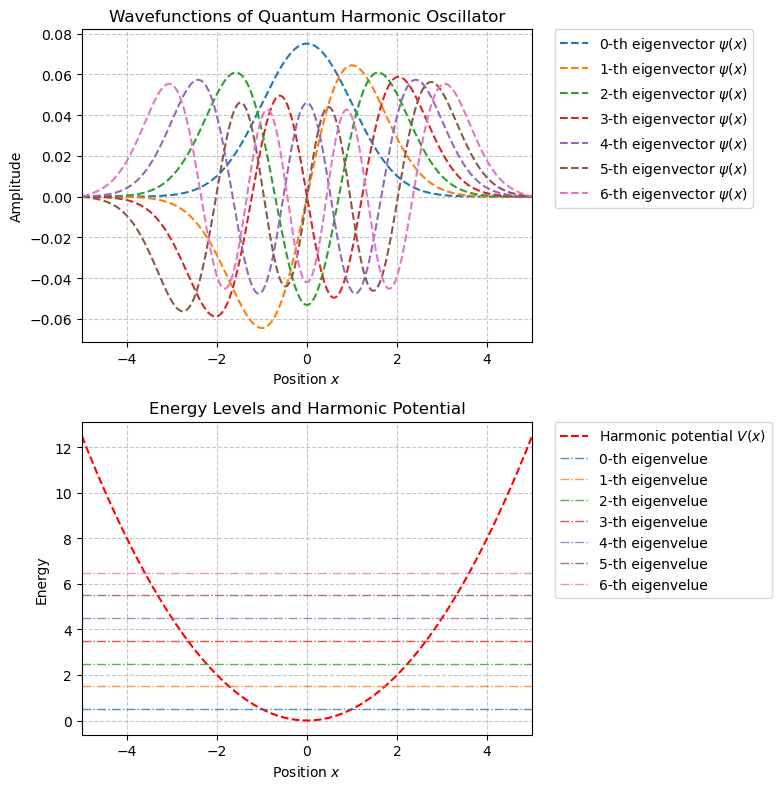

In [13]:
plot(k, eigenvalues, eigenvectors)

In [14]:
eigenvalues = []
eigenvectors = []

for i in range(k):
    wavefunction = anso.harmonic_wfc(x_i, omega, i)
    
    norm = np.sqrt(np.sum(np.abs(wavefunction)**2))
    eigenvector = wavefunction / norm
    
    eigenvalue = anso.harmonic_en(omega, i)
    
    eigenvalues.append(eigenvalue)
    eigenvectors.append(eigenvector)

eigenvalues = np.array(eigenvalues)
eigenvectors = np.array(eigenvectors)

In [15]:
print(k)

7


In [16]:
print(len(eigenvalues))

7


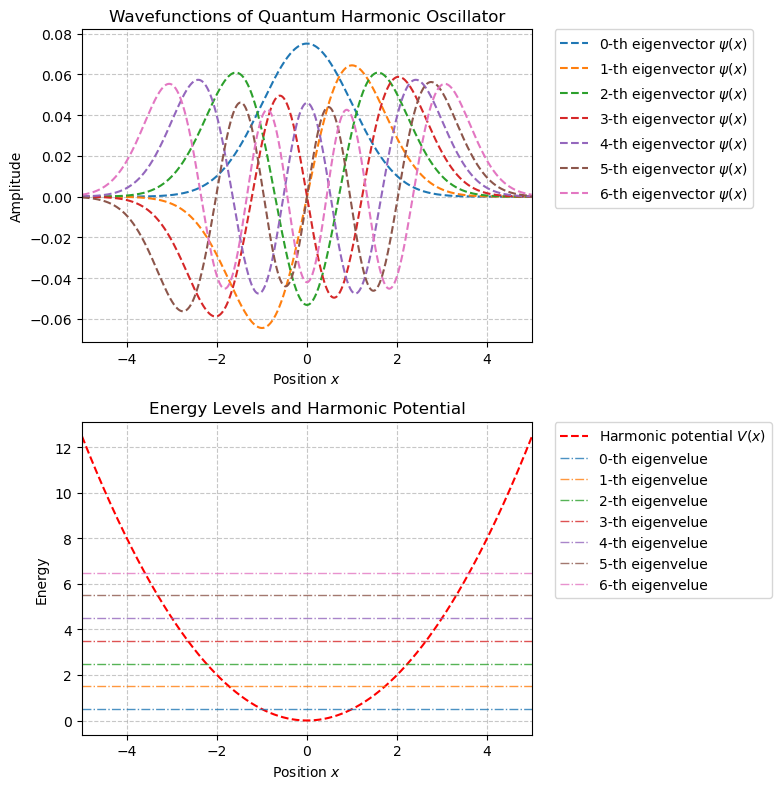

In [17]:
plot(k, eigenvalues, eigenvectors)